# Advanced linear regression

In [2]:
import jax
import jax.scipy.optimize as jso
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from functools import partial
from typing import Callable, NamedTuple, Optional, Union
from jax import lax

plt.style.use("ggplot")

jnp = jax.numpy
random = jax.random

In [65]:
class LinearRegressionParams(NamedTuple):
    sigma: Union[float, jnp.array]
    beta: jnp.array

def flatten_params(params):
    """Flatten and unconstrain parameters"""
    value_flat, value_tree = tree_flatten(LinearRegressionParams(
        sigma=jnp.log(params.sigma).reshape(1),
        beta=params.beta,
    ))
    sizes = tuple(val.shape[0] for val in value_flat)
    value_flat = jnp.concatenate(value_flat)
    return value_flat, (sizes, value_tree)

def unflatten_params(value_flat, tree_struct):
    """Unflatten and re-constrain parameters"""
    sizes, value_tree = tree_struct
    
    value_flat_list = []
    idx = 0
    for size in sizes:
        value_flat_list.append(value_flat[idx: idx+size])
        idx += size
    
    transformed_params = tree_unflatten(value_tree, value_flat_list)
    return LinearRegressionParams(
        sigma=jnp.exp(transformed_params.sigma),
        beta=transformed_params.beta,
    )


In [66]:
key = random.PRNGKey(20220519)

n = 100
p = 4

key, skey = random.split(key)
params = LinearRegressionParams(
    sigma=0.1,
    beta=random.normal(skey, (p,))
)

key, skey = random.split(key)
x = random.normal(skey, (n, p))

def sample_y(key, params, x):
    eps = random.normal(key, (n,))
    return x @ params.beta + params.sigma * eps

key, skey = random.split(key)
y = sample_y(skey, params, x)


def neg_loglik(params, x, y):
    y_hat = x @ params.beta
    loglik = jax.scipy.stats.norm.logpdf(y - y_hat, scale=params.sigma)
    return -loglik.mean()

neg_loglik(params, x, y)

DeviceArray(-0.902052, dtype=float32)

In [67]:
from jax.tree_util import tree_flatten, tree_unflatten

value_flat, value_tree = tree_flatten(params)

In [68]:
value_flat, tree_struct = flatten_params(params)

In [69]:
unflatten_params(value_flat, tree_struct)

LinearRegressionParams(sigma=DeviceArray([0.09999999], dtype=float32), beta=DeviceArray([ 1.1385529 ,  0.5513186 ,  0.08600916, -0.385452  ], dtype=float32))

In [136]:
init_params = LinearRegressionParams(
    sigma=1.0,
    beta=jnp.zeros(p),
)

def flat_loss(flat_params, x, y, tree_struct):
    params = unflatten_params(flat_params, tree_struct)
    return neg_loglik(params, x, y)

@jax.jit
def fit_params(init_params, x, y):
    x0, tree_struct = flatten_params(init_params)
    res = jso.minimize(flat_loss, x0, args=(x, y, tree_struct), method="BFGS")
    params_hat = unflatten_params(res.x, tree_struct)
    return params_hat


In [137]:
%%time
params_hat = fit_params(init_params, x, y)
flat_params_hat, _ = flatten_params(params_hat)

CPU times: user 698 ms, sys: 33.7 ms, total: 732 ms
Wall time: 697 ms


In [145]:
h = jax.hessian(flat_loss)(flat_params_hat, x, y, tree_struct)
ih = jnp.linalg.inv(h)
sqrt_diag = jnp.sqrt(jnp.diag(ih))
corr = (ih / sqrt_diag).T / sqrt_diag

In [146]:
corr

DeviceArray([[ 1.00000000e+00,  4.81044772e-05, -2.30594505e-05,
               1.22087877e-05, -5.76472530e-06],
             [ 4.81146089e-05,  1.00000012e+00, -1.24895778e-02,
               1.24618048e-02,  4.88671921e-02],
             [-2.30391361e-05, -1.24895787e-02,  1.00000000e+00,
               9.76005793e-02, -2.82335859e-02],
             [ 1.22280999e-05,  1.24618085e-02,  9.76005569e-02,
               1.00000000e+00, -9.67659578e-02],
             [-5.78746040e-06,  4.88671996e-02, -2.82335710e-02,
              -9.67659354e-02,  1.00000012e+00]], dtype=float32)

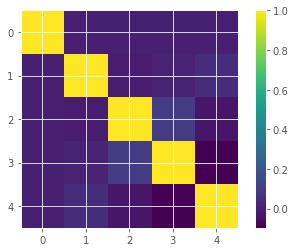

In [148]:
plt.imshow(corr)
plt.colorbar()

In [149]:
sqrt_diag

DeviceArray([0.7071046 , 0.10398776, 0.10498977, 0.09096138, 0.09407349],            dtype=float32)

In [179]:
# Verification by Bootstrap


def replicate(key, params, x):
    y = sample_y(key, params, x)
    init_params = LinearRegressionParams(
        sigma=1.0,
        beta=jnp.zeros(p),
    )
    params_hat = fit_params(init_params, x, y)
    return params_hat

n_replications = 10_000
bootstrap = jax.jit(jax.vmap(replicate, in_axes=(0, None, None)))


In [180]:
%%time

keys = random.split(key, n_replications)
params_s = bootstrap(keys, params, x)

CPU times: user 10.9 s, sys: 2.47 s, total: 13.4 s
Wall time: 5.74 s


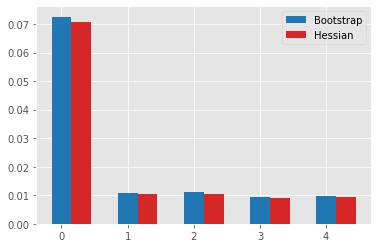

In [192]:

plt.bar(1 + jnp.arange(p), params_s.beta.std(axis=0), width=0.3, label="Bootstrap", color="tab:blue")
plt.bar(1 + jnp.arange(p) + .3, sqrt_diag[1:] / jnp.sqrt(n), width=0.3, label="Hessian", color="tab:red")

plt.bar(jnp.arange(1), jnp.log(params_s.sigma).std(axis=0), width=0.3, color="tab:blue")
plt.bar(jnp.arange(1) + .3, sqrt_diag[0] / jnp.sqrt(n), width=0.3, color="tab:red")


plt.legend()